In [1]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml("mnist_784")

In [2]:
def euclidean_distance(X, Y):
    tmp1 = np.sum(X**2, axis=1)
    tmp2 = np.sum(Y**2, axis=1)
    rr = tmp1[:, np.newaxis] - 2 * np.dot(X, Y.T) + tmp2[:, np.newaxis].T
    rr = np.maximum(rr, 0)
    return (rr)**0.5
def cosine_distance(X, Y):
    tmp1 = (np.sum(X**2, axis=1))**0.5
    tmp2 = (np.sum(Y**2, axis=1))**0.5
    return 1 - np.dot(X, Y.T)/(tmp1[:, np.newaxis] * tmp2[:, np.newaxis].T + 1e-5)
    
    

In [3]:
import numpy as np
import sklearn
from sklearn.neighbors import NearestNeighbors


class KNNClassifier:
    def __init__(self, k, strategy, metric, weights, test_block_size):
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.block = test_block_size
        
    def fit(self, X, y):
        self.y = np.copy(y).astype(int)
        if self.strategy == 'my_own':
            self.X = np.copy(X)
        else:
            self.model = sklearn.neighbors.NearestNeighbors(algorithm=self.strategy, n_neighbors=self.k,
                                                            metric=self.metric).fit(X, y)        
    def find_kneighbors(self, X, return_distance):
        if self.strategy != 'my_own':
            return self.model.kneighbors(X, return_distance=return_distance)
        if self.metric == 'euclidean':
            dist = euclidean_distance(X, self.X)
        elif self.metric == 'cosine':
            dist = cosine_distance(X, self.X)
        sort_dist = np.sort(dist, axis=1)[:, :self.k]
        sort_ind = np.argsort(dist, axis=1)[:, :self.k]
        if return_distance:
            return sort_dist, sort_ind.astype(int)
        return sort_ind.astype(int) 
    
    def predict(self, X):
        eps = 1e-5
        res = np.array([])
        for j in range((X.shape[0] - 1) // self.block + 1):
            dist, ind = self.find_kneighbors(X[j * self.block : (j + 1) * self.block], return_distance=True)
            weights = np.ones_like(dist, dtype=float)
            if self.weights:
                    weights = 1 / (dist + eps)
            for r in range(ind.shape[0]):
                res = np.append(res, np.bincount(self.y[ind[r]], weights=weights[r]).argmax())            
        return res.astype(int)
 
      

In [4]:
import random
import numpy as np
from sklearn.model_selection import StratifiedKFold

    
def kfold(n, n_folds):
    ind = np.arange(n)
    random.shuffle(ind)
    res_list = []
    size = n // n_folds
    num_add_size = n % n_folds
    left = 0
    right = 0
    for i in range(n_folds):
        if (i < num_add_size):
            right += size + 1
            test = ind[left: right]
            train = np.append(ind[:left], ind[right:])      
        else:
            right += size
            test = ind[left: right]
            train = np.append(ind[:left], ind[right:])
        left = right    
        res_list.append((train, test))
    return res_list

def accuracy(y, z):
    return np.equal(y, z).astype(int).sum() / len(y)

def cross_predict(dist, ind, y, w):
    res = np.array([])
    eps = 1e-5
    weights = np.ones_like(dist, dtype=float)
    if w:
        weights = 1 / (dist + eps)
    for r in range(ind.shape[0]):
        res = np.append(res, np.bincount(y[ind[r]], weights[r]).argmax())
    return res.astype(int)
    
def knn_cross_val_score(X, y, k_list, score, cv, **kwargs): 
    if cv is None:
        cv = kfold(len(y), 3)
    res = {}
    for k in k_list:
        res[k] = np.array([])
    for train, test in cv:
        knn_obj = KNNClassifier(k_list[-1], **kwargs)
        knn_obj.fit(X[train], y[train])
        dist, ind  = knn_obj.find_kneighbors(X[test], True)
        for k in k_list:
            res[k] = np.append(res[k], accuracy(y[test], cross_predict(dist[:, :k], ind[:, :k], y[train],
                                                                       knn_obj.weights)))
    return res

    

In [5]:
X = mnist.data / 255
y = mnist.target.astype(int)

In [6]:
trainX = X[:60000]
trainy = y[:60000]
testX = X[60000:]
testy = y[60000:]

In [169]:
time_my_own = {}
time_brute = {}
time_kd_tree = {}
time_ball_tree = {}

In [7]:
import time

In [22]:
features = random.sample(list(range(X.shape[1])), 100)

In [242]:
%%time
a = KNNClassifier(k=5, strategy = "my_own", metric="euclidean", weights=False, test_block_size=100)
a.fit(trainX[:, features], trainy)
begin = time.time()
test_block = 100
for j in range((testX.shape[0] - 1) // test_block + 1):
    a.find_kneighbors(testX[j * test_block : (j + 1) * test_block, features], False)
a.find_kneighbors(testX[:test_block, features], False)
end = time.time()
time_my_own['100'] = end - begin

CPU times: user 1min 52s, sys: 2.45 s, total: 1min 54s
Wall time: 1min 32s


In [8]:
import pandas as pd

In [258]:

data = [["my_own", 10, time_my_own["10"]], ["my_own", 20, time_my_own["20"]], ["my_own", 100, time_my_own["100"]],
       ["brute", 10, time_brute["10"]], ["brute", 20, time_brute["20"]], ["brute", 100, time_brute["100"]],
       ["kd_tree", 10, time_kd_tree["10"]], ["kd_tree", 20, time_kd_tree["20"]], ["kd_tree", 100, time_kd_tree["100"]],
       ["ball_tree", 10, time_ball_tree["10"]], ["ball_tree", 20, time_ball_tree["20"]], 
        ["ball_tree", 100, time_ball_tree["100"]]]
pd.DataFrame(data, columns=["algorithm", "number of features", "time"])

In [38]:
data1 = []
res = knn_cross_val_score(trainX, trainy, list(range(1, 11)), "accuracy", None, strategy = "brute", 
                          metric="cosine", weights=True, test_block_size=100)
for key in res.keys():
    data1.append([key, np.mean(res[key])])


In [39]:
df = pd.DataFrame(data1, columns=["k", "cosine"])
df

,k,cosine
0,1,0.973200
1,2,0.973200
2,3,0.974517
3,4,0.975150
4,5,0.973950
5,6,0.974133
6,7,0.971917
7,8,0.972450
8,9,0.970733
9,10,0.971233


In [42]:
data2 = []
for metric in ["euclidean", "cosine"]:
    begin = time.time()
    res = knn_cross_val_score(trainX, trainy, [10], "accuracy", None, strategy = "brute", 
                          metric=metric, weights=True, test_block_size=100)
    end = time.time()
    for val in res:
        data2.append([metric, np.mean(res[val]), end - begin])

In [43]:
data2

[['euclidean', 0.9667666666666667, 90.0689971446991],
 ['cosine', 0.9713166666666666, 86.09545612335205]]

In [46]:
df = pd.DataFrame(data2, columns=["metric", "accuracy", "time"])
df.to_csv("test2b")

In [38]:
cv = kfold(len(trainy), 3)
data3 = []

In [39]:
for w in [True, False]:
    res = knn_cross_val_score(trainX, trainy, list(range(1, 11)), "accuracy", cv, strategy = "brute", 
                          metric="cosine", weights=w, test_block_size=100)
    for key in res.keys():
        data3.append([w, key, np.mean(res[key])])

In [41]:
df = pd.DataFrame(data3, columns=["weights", "k", "accuracy"])
df.to_csv("test3.csv")

Лучший - brute, cosine

In [9]:
a = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True, test_block_size=100)
a.fit(trainX, trainy)
pred = a.predict(testX)

In [10]:
accuracy(pred, testy)

0.9752

In [11]:
import matplotlib.pyplot as plt

In [22]:
mask = np.where(pred != testy)[0]
diff_ind = random.sample(list(mask), 6)

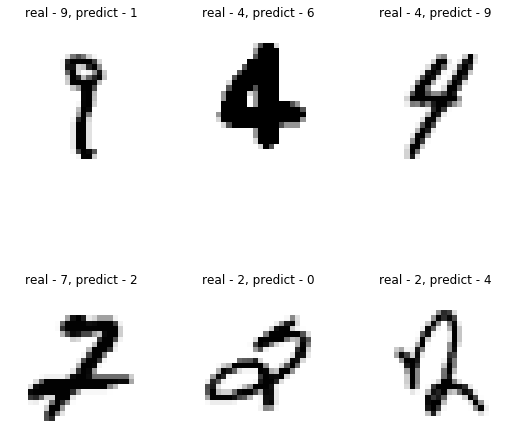

In [23]:
f = plt.figure(figsize=(9, 9))
for i, k in enumerate(diff_ind):   
    plt.subplot(2, 3, i + 1)
    plt.axis("Off")
    plt.imshow(testX[k].reshape(28, -1), cmap="Greys")
    plt.title("real - " + str(testy[k]) +  ", predict - " + str(pred[k]))
    


In [24]:
f.savefig("lala.png")

In [22]:
from sklearn.metrics import confusion_matrix

In [41]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Матрица ошибок'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Матрица ошибок')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Истинный класс',
           xlabel='Предсказанный класс')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig("conf_mat1.pdf")
    return ax

In [39]:
cm = confusion_matrix(testy, pred, labels=list(range(10)))
cm

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]])

In [21]:
from sklearn.utils.multiclass import unique_labels

Матрица ошибок
[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1129    3    1    0    0    2    0    0    0]
 [   8    0 1009    1    1    0    0    8    5    0]
 [   0    1    3  976    1   12    0    4    9    4]
 [   2    1    0    0  946    0    6    2    0   25]
 [   4    0    0    9    1  863    7    1    4    3]
 [   3    3    0    0    1    3  948    0    0    0]
 [   2   10    4    0    1    0    0  998    0   13]
 [   7    1    2    9    3    3    5    4  936    4]
 [   7    7    2    5    7    3    1    4    3  970]]


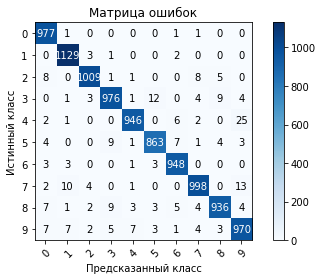

In [40]:
 plot_confusion_matrix(testy, pred, classes=np.array(range(10)))


In [325]:
df = pd.DataFrame(cm, columns=list(range(10)))
df.to_csv("conf.csv")

In [13]:
import scipy.ndimage

In [14]:
train_img = trainX.reshape(-1, 28, 28)
scipy.ndimage.rotate(train_img[0], angle=15).shape

(34, 34)

In [15]:
def transform(images, angle, roll_val, roll_axis, sigma):
    res = scipy.ndimage.rotate(images, angle=angle, axes = (1, 2))
    res = np.roll(res, roll_val, axis=roll_axis)
    res = scipy.ndimage.gaussian_filter(res, sigma=(0, sigma, sigma))
    return res

In [16]:
from tqdm import tqdm_notebook as tqdm

In [81]:
%%time
data4 = []
for angle in tqdm([-15, -10, -5, 5, 10, 15]):
    i = abs(angle) // 5
    transformed = transform(train_img, angle=angle, roll_val=0, roll_axis=1, sigma=0)[:, i:-i, i:-i]
    transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
    cv = kfold(len(trainy), 3)
    cv1 = []
    for tr, tes in cv:
        cv1.append((np.append(tr, tr + 60000), tes))    
    res1 = knn_cross_val_score(np.append(trainX, transformed, axis=0), np.append(trainy, trainy), [5], "accuracy",
                               cv1, strategy = "brute", metric="euclidean", weights=True, test_block_size=100)
    for key in res1.keys():
        data4.append([angle, np.mean(res1[key])])

CPU times: user 26min 7s, sys: 2min 20s, total: 28min 27s
Wall time: 19min 18s


Лучшее: угол -5, сдвиг по оси 1 1,сигма 1

In [ ]:
data4 = []
for angle in tqdm([-15, -10, -5, 0, 5, 10, 15]):
    for shift_px in tqdm([-3, -2, -1, 0, 1, 2, 3]):
        for shift_axis in tqdm([1, 2]):
            for sigma in tqdm([0, 0.5, 1, 1.5]):
                transformed = transform(train_img, angle, shift_px, shift_axis, sigma)
                transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
                res1 = knn_cross_val_score(transformed, trainy, [5], "accuracy", None,
                                           strategy = "brute", metric="euclidean", weights=True, test_block_size=100)
                for key in res1.keys():
                    data4.append([angle, shift_px, shift_axis, sigma, np.mean(res1[key])])

In [42]:
transformed = transform(train_img, angle=-5, roll_val=1, roll_axis=1, sigma=1)[:, 1:29, 1:29]
transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
new_X = np.append(trainX, transformed, axis=0)
transformed = transform(train_img, angle=-5, roll_val=0, roll_axis=1, sigma=1)[:, 1:29, 1:29]
transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
new_X = np.append(new_X, transformed, axis=0)
transformed = transform(train_img, angle=-5, roll_val=0, roll_axis=1, sigma=0)[:, 1:29, 1:29]
transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
new_X = np.append(new_X, transformed, axis=0)
transformed = transform(train_img, angle=0, roll_val=0, roll_axis=1, sigma=1)
transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
new_X = np.append(new_X, transformed, axis=0)
new_y = np.append(trainy, trainy)
new_y = np.append(new_y, new_y)
new_y = np.append(new_y, trainy)

In [43]:
a = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True, test_block_size=100)
a.fit(new_X, new_y)

In [44]:
pred1 = a.predict(testX)
accuracy(pred1, testy)

0.9831

In [45]:
cm1 = confusion_matrix(testy, pred1, labels=list(range(10)))
cm1

array([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1131,    3,    0,    0,    0,    1,    0,    0,    0],
       [   3,    2, 1013,    2,    1,    0,    1,   10,    0,    0],
       [   0,    0,    2,  990,    1,    6,    0,    4,    6,    1],
       [   0,    1,    0,    0,  964,    0,    4,    0,    0,   13],
       [   1,    1,    0,    5,    1,  874,    7,    1,    0,    2],
       [   3,    3,    0,    0,    1,    2,  949,    0,    0,    0],
       [   1,    8,    5,    2,    2,    0,    0,  999,    0,   11],
       [   1,    0,    2,    4,    3,    4,    6,    3,  948,    3],
       [   2,    4,    0,    1,    6,    3,    1,    5,    2,  985]])

Матрица ошибок
[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1131    3    0    0    0    1    0    0    0]
 [   3    2 1013    2    1    0    1   10    0    0]
 [   0    0    2  990    1    6    0    4    6    1]
 [   0    1    0    0  964    0    4    0    0   13]
 [   1    1    0    5    1  874    7    1    0    2]
 [   3    3    0    0    1    2  949    0    0    0]
 [   1    8    5    2    2    0    0  999    0   11]
 [   1    0    2    4    3    4    6    3  948    3]
 [   2    4    0    1    6    3    1    5    2  985]]


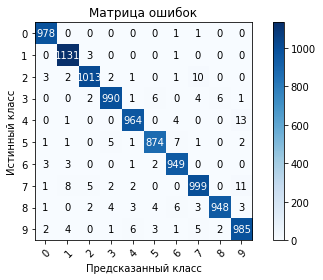

In [46]:
 plot_confusion_matrix(testy, pred1, classes=np.array(range(10)))

In [26]:
a = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True, test_block_size=100)
a.fit(trainX, trainy)


In [27]:
test_img = testX.reshape(-1, 28, 28)

In [28]:
dist_base, ind_base = a.find_kneighbors(testX, True)

In [152]:
%%time
data4 = []
for angle in tqdm([-15, -10, -5, 5, 10, 15]):
    i = abs(angle) // 5
    transformed = transform(test_img, angle=angle, roll_val=0, roll_axis=1, sigma=0)[:, i:-i, i:-i]
    transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
    dist_tr, ind_tr = a.find_kneighbors(transformed, True)
    dist = np.append(dist_base, dist_tr, axis=1)
    ind_ind = np.argsort(dist, axis=1)
    dist = np.sort(dist, axis=1)[:, :5]
    ind = np.append(ind_base, ind_tr, axis=1)
    weights = np.ones_like(dist, dtype=float)
    weights = 1 / (dist + 1e-5)
    res = np.array([])
    for r in range(ind.shape[0]):
        ind_str = ind[r]
        ind_mask = ind_ind[r]
        res = np.append(res, np.bincount(trainy[ind_str[ind_mask][:5]], weights=weights[r]).argmax())            
    pred1 = res.astype(int)
    data4.append([angle, accuracy(pred1, testy)])

CPU times: user 3min 11s, sys: 19.9 s, total: 3min 31s
Wall time: 2min 26s


In [175]:
%%time
data4 = []
for shift_axis in tqdm([1, 2]):
    for shift_px in tqdm([-3, -2, -1, 0, 1, 2, 3]):
        
        i = abs(angle) // 5
        transformed = transform(test_img, angle=0, roll_val=shift_px, roll_axis=shift_axis, sigma=0)
        transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
        dist_tr, ind_tr = a.find_kneighbors(transformed, True)
        dist = np.append(dist_base, dist_tr, axis=1)
        ind_ind = np.argsort(dist, axis=1)
        dist = np.sort(dist, axis=1)[:, :5]
        ind = np.append(ind_base, ind_tr, axis=1)
        weights = np.ones_like(dist, dtype=float)
        weights = 1 / (dist + 1e-5)
        res = np.array([])
        for r in range(ind.shape[0]):
            ind_str = ind[r]
            ind_mask = ind_ind[r]
            res = np.append(res, np.bincount(trainy[ind_str[ind_mask][:5]], weights=weights[r]).argmax())            
        pred1 = res.astype(int)
        data4.append([shift_axis, shift_px, accuracy(pred1, testy)])

CPU times: user 7min 13s, sys: 43.3 s, total: 7min 57s
Wall time: 5min 26s


In [178]:
df = pd.DataFrame(data4, columns=["shaift_axis", "shift_px", "accuracy"])
df["accuracy"] = df["accuracy"].round(4)
df.to_csv("test_trans_shift.csv", index=False)

сдвиг 1 1. угол сигма 0 угол -10

In [29]:
transformed = transform(test_img, angle=0, roll_val=1, roll_axis=1, sigma=0)
transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
dist_tr, ind_tr = a.find_kneighbors(transformed, True)
dist = np.append(dist_base, dist_tr, axis=1)
ind = np.append(ind_base, ind_tr, axis=1)

transformed = transform(test_img, angle=-10, roll_val=0, roll_axis=1, sigma=0)[:, 2:30, 2:30]
transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
dist_tr, ind_tr = a.find_kneighbors(transformed, True)
dist = np.append(dist, dist_tr, axis=1)
ind = np.append(ind, ind_tr, axis=1)

transformed = transform(test_img, angle=-10, roll_val=1, roll_axis=1, sigma=0)[:, 2:30, 2:30]
transformed = transformed.reshape(-1, transformed.shape[1] * transformed.shape[2])
dist_tr, ind_tr = a.find_kneighbors(transformed, True)
dist = np.append(dist, dist_tr, axis=1)
ind = np.append(ind, ind_tr, axis=1)



ind_ind = np.argsort(dist, axis=1)
dist = np.sort(dist, axis=1)[:, :5]
weights = np.ones_like(dist, dtype=float)
weights = 1 / (dist + 1e-5)

        

In [197]:
ind_ind.shape

(10000, 20)

In [30]:
res = np.array([])
for r in range(ind.shape[0]):
    ind_str = ind[r]
    ind_mask = ind_ind[r]
    res = np.append(res, np.bincount(trainy[ind_str[ind_mask][:5]], weights=weights[r]).argmax())            
pred1 = res.astype(int)

In [31]:
accuracy(pred1, testy)

0.9803

Матрица ошибок
[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [   9    0 1005    0    0    0    0   14    4    0]
 [   0    0    1  985    1    6    0    5    7    5]
 [   2    2    0    0  946    0    6    2    1   23]
 [   5    0    0    9    1  867    2    1    5    2]
 [   4    3    0    0    0    2  947    0    2    0]
 [   1    3    4    0    0    1    0 1014    0    5]
 [   4    0    1    6    2    2    0    5  950    4]
 [   7    3    2    2    2    3    0    9    2  979]]


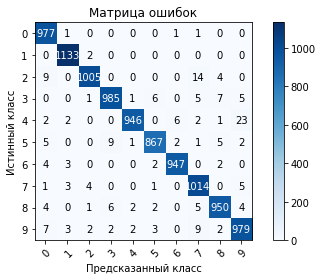

In [37]:
 plot_confusion_matrix(testy, pred1, classes=np.array(range(10)))